In [9]:
# Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

In [10]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [11]:
URL = r"https://www.dropbox.com/s/zuwnn6rqe0f4zgh/opencv_bootcamp_assets_NB8.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), f"opencv_bootcamp_assets_NB8.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)  

In [14]:
# read reference image
refFilename = 'form.jpg'
print('Reading reference image : ', refFilename)
im1 = cv2.imread(refFilename, cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

# read image to be aligned
imFilename = 'scanned-form.jpg'
print('Reading image to aligned : ', imFilename)
im2 = cv2.imread(imFilename, cv2.IMREAD_COLOR)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)


Reading reference image :  form.jpg
Reading image to aligned :  scanned-form.jpg


Text(0.5, 1.0, 'Scanned Image')

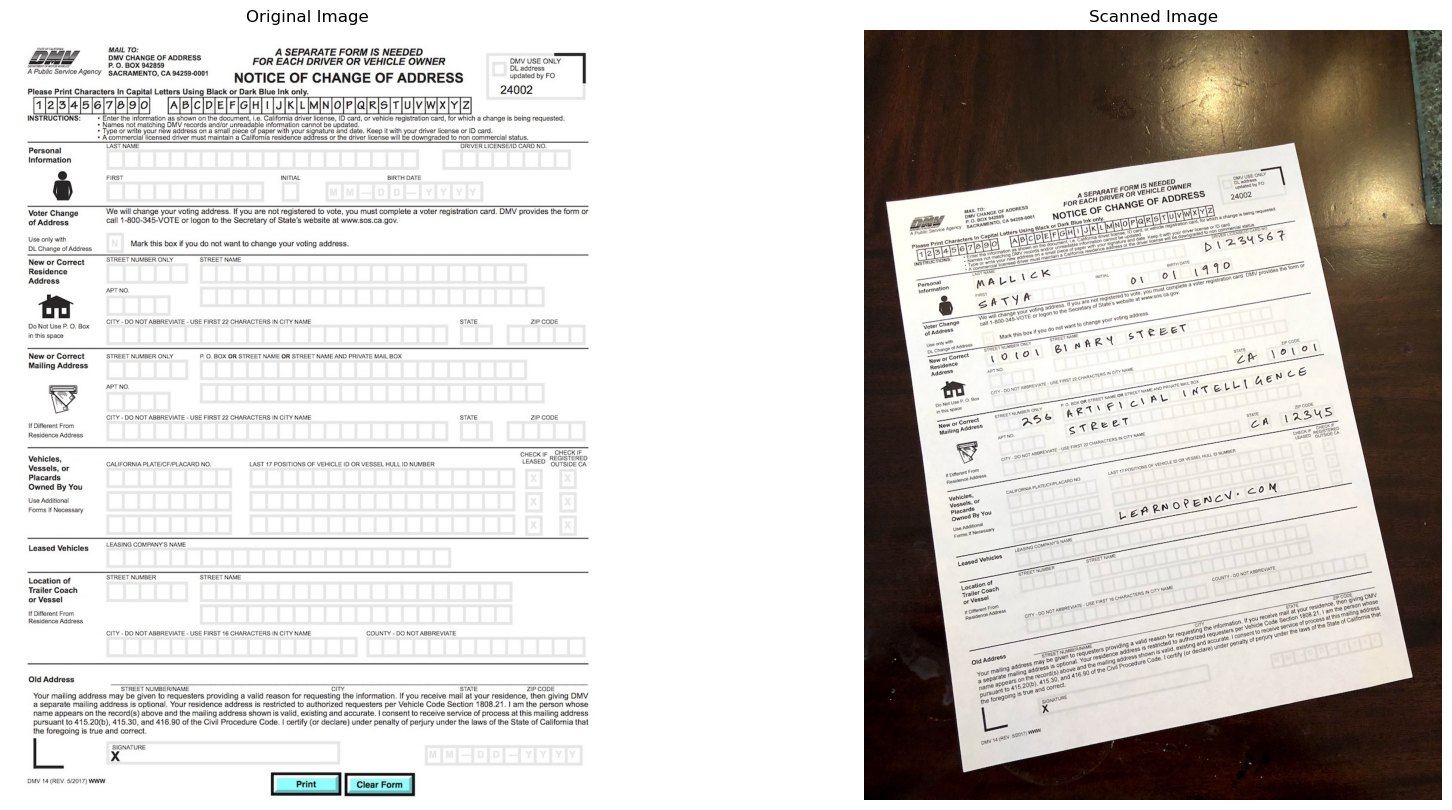

In [15]:
# display images
plt.figure(figsize=[20,10])
plt.subplot(121); plt.axis('off'); plt.imshow(im1); plt.title('Original Image')
plt.subplot(122); plt.axis('off'); plt.imshow(im2); plt.title('Scanned Image')

### Step 2: Find key points in both images

In [17]:
# convert images to gray scale
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

# detect ORB features and compute descriptors
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(im2_gray, None)

# display
im1_display = cv2.drawKeypoints(im1, keypoints1, outImage=np.array([]), color=(255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
im2_display = cv2.drawKeypoints(im2, keypoints2, outImage=np.array([]), color=(255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

Text(0.5, 1.0, 'Scanned Image')

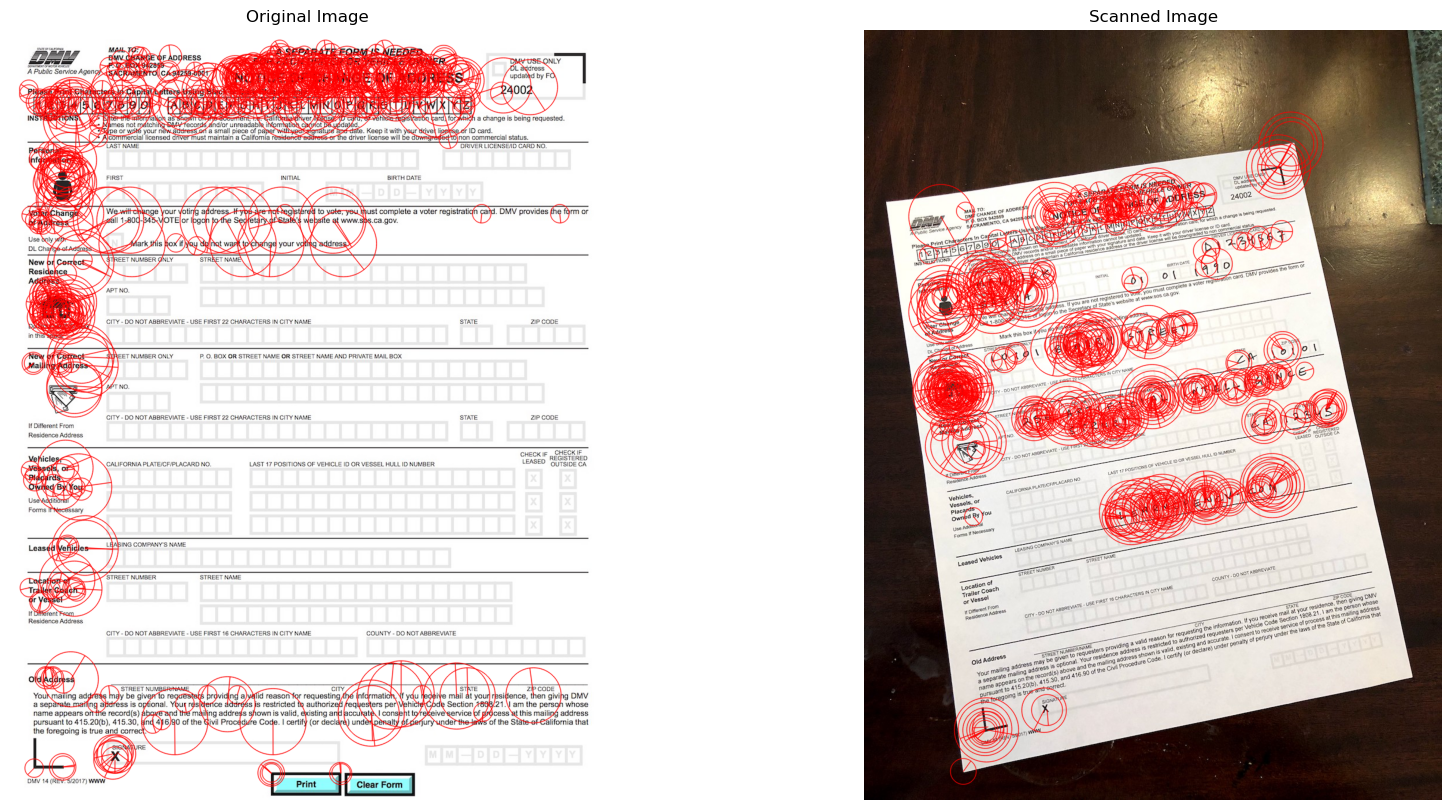

In [18]:
plt.figure(figsize=[20,10])
plt.subplot(121); plt.axis('off'); plt.imshow(im1_display); plt.title('Original Image')
plt.subplot(122); plt.axis('off'); plt.imshow(im2_display); plt.title('Scanned Image')

### Step 3: Match key points in two images

In [21]:
# Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

# Converting to list for sorting as tuples are immutable objects.
matches = list(matcher.match(descriptors1, descriptors2, None))

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
numGoodMatches = int(len(matches) * 0.1)
matches = matches[:numGoodMatches]

Text(0.5, 1.0, 'Original Form')

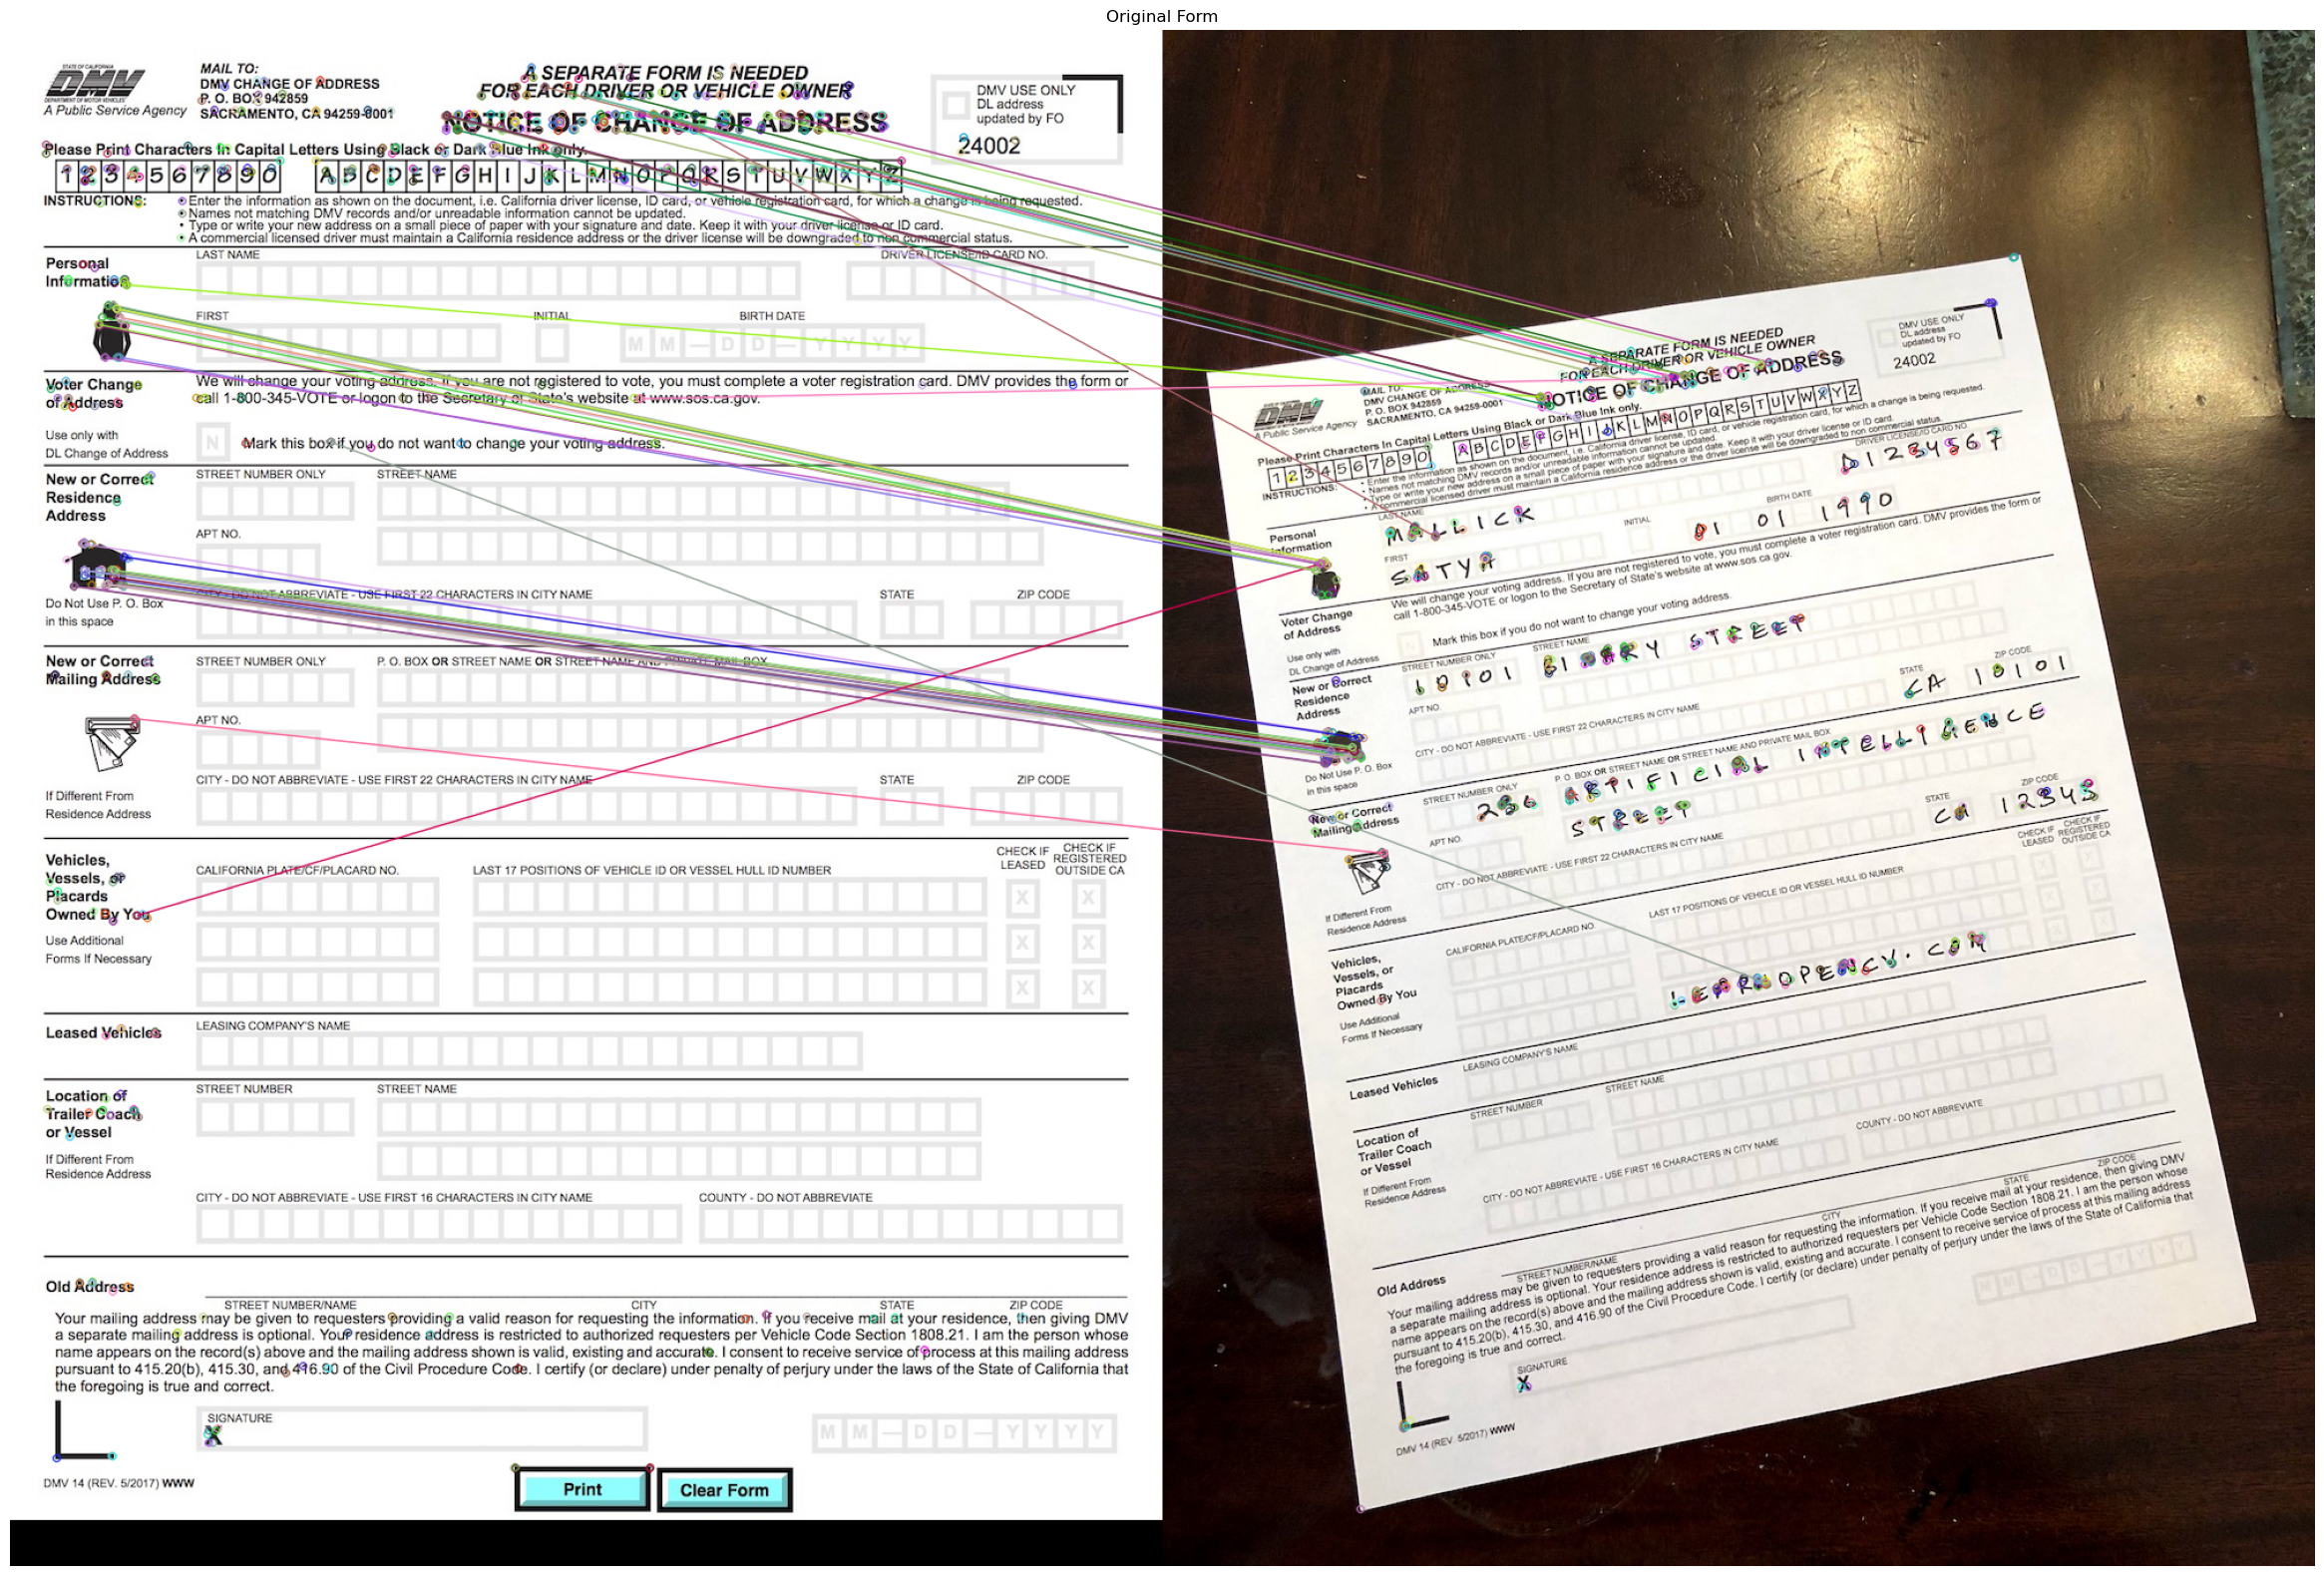

In [22]:
# draw top matches
im_matches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

plt.figure(figsize=[40,20])
plt.imshow(im_matches); plt.axis('off'); plt.title('Original Form')

### Step 4: Find Homography

In [24]:
# extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

### Step 5: Warp Images

Text(0.5, 1.0, 'Scanned Image')

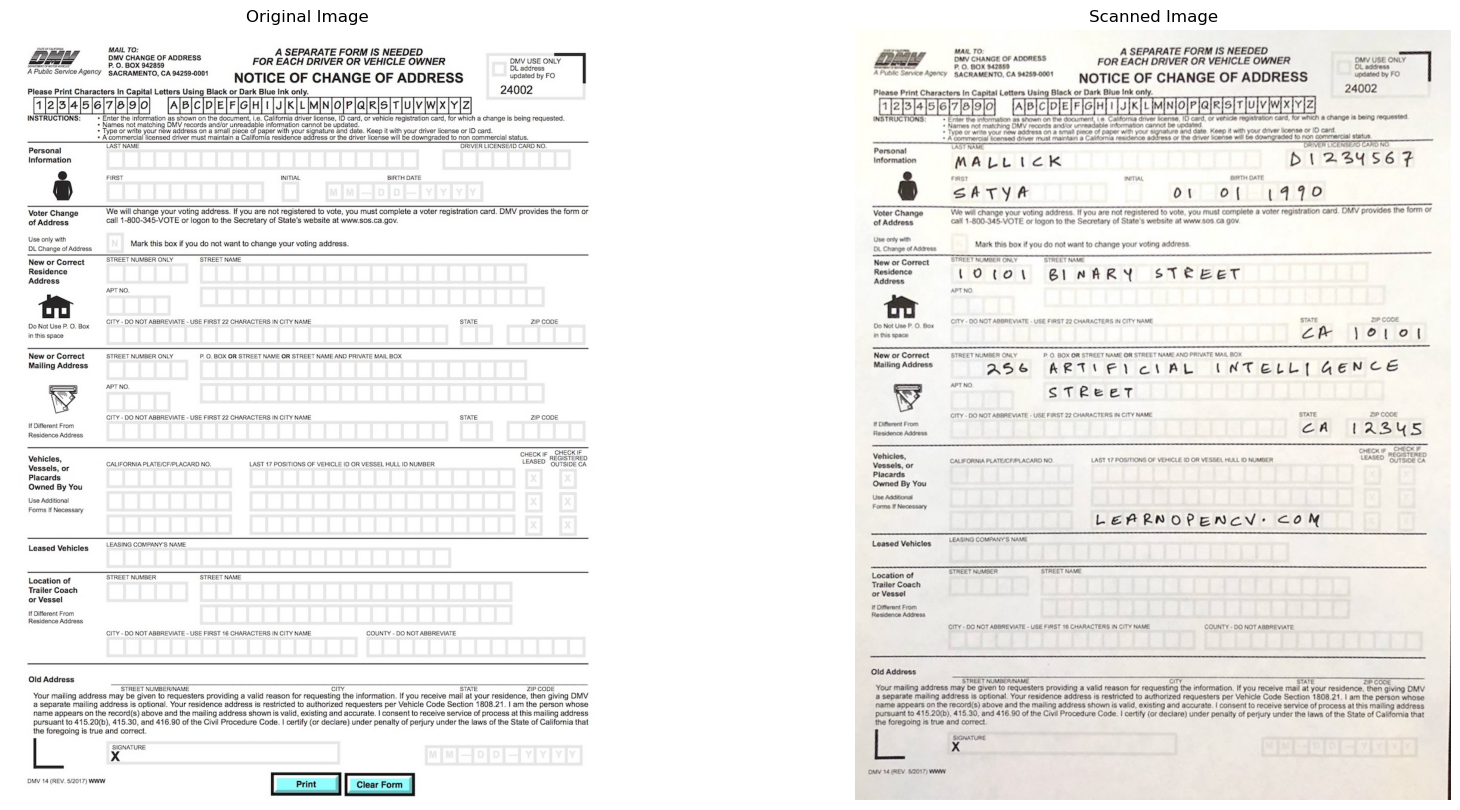

In [25]:
# use homography to warp image
height, width, channels = im1.shape
im2_reg = cv2.warpPerspective(im2, h, (width,height))

# display results
plt.figure(figsize=[20,10])
plt.subplot(121); plt.axis('off'); plt.imshow(im1); plt.title('Original Image')
plt.subplot(122); plt.axis('off'); plt.imshow(im2_reg); plt.title('Scanned Image')